In [13]:
import numpy as np
import ast
import urllib
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import scbalancedipy.optimize
from sklearn import linear_model
import math

In [14]:
def parseDataFromFile(fname):
    """ Read and convert the input to a list of dicts"""
    for l in open(fname, encoding="utf-8"):
        yield ast.literal_eval(l)

In [15]:
fname = "C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\train.json"
dataset = list(parseDataFromFile(fname))
training_validation_boundary = 165000
training_dataset = dataset[:training_validation_boundary]
validation_dataset = dataset[training_validation_boundary:]

In [16]:
print(dataset[0])

{'hours': 0.3, 'gameID': 'b96045472', 'hours_transformed': 0.37851162325372983, 'early_access': False, 'date': '2015-04-08', 'text': '+1', 'userID': 'u01561183'}


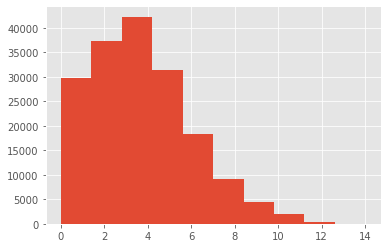

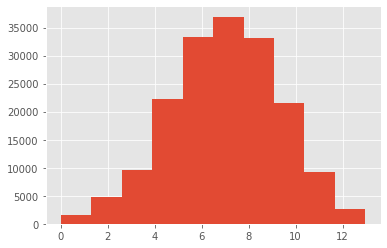

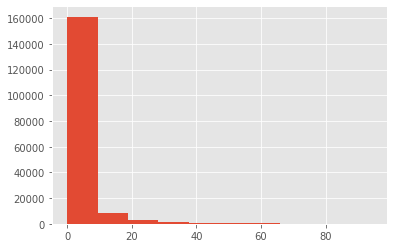

In [5]:
import matplotlib.pyplot as plt
hours = []
for d in dataset:
    hours.append(d['hours_transformed'])
plt.style.use('ggplot')
plt.hist(hours, bins=10)
plt.show()

text_lengths = []
for d in dataset:
    text_lengths.append(math.log2(len(d['text']) + 1))
plt.style.use('ggplot')
plt.hist(text_lengths,bins=10)
plt.show()

correlation = []
for d in dataset:
    if(d['hours_transformed']):
        ratio = math.log2(len(d['text']) + 1) / d['hours_transformed']
    else:
        ratio = math.log2(len(d['text']) + 1)
    correlation.append(ratio)
plt.style.use('ggplot')
plt.hist(correlation,bins=10)
plt.show()

Preparing the modified validation set by adding negative samples

In [18]:
usersPerGame = defaultdict(set) # list of userIDs per game
gamesPerUser = defaultdict(set) # list of gameIDs per user
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
gameIDs = [] # This contains the entire list of games

usersPerGame_training = defaultdict(set) # list of userIDs per game
gamesPerUser_training = defaultdict(set) # list of gameIDs per user
reviewsPerUser_training = defaultdict(list)
reviewsPerGame_training = defaultdict(list)
gameIDs_training = [] # This contains the entire list of games

usersPerGame_validation = defaultdict(set) # list of userIDs per game
gamesPerUser_validation = defaultdict(set) # list of gameIDs per user
reviewsPerUser_validation = defaultdict(list)
reviewsPerGame_validation = defaultdict(list)
gameIDs_validation = [] # This contains the entire list of games

# Computing maps and lists for all samples
for d in dataset:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame[gameID].add(userID)
    gamesPerUser[userID].add(gameID)
    reviewsPerUser[userID].append(d)
    reviewsPerGame[gameID].append(d)
    if gameID not in gameIDs:
        gameIDs.append(gameID)
        
# Computing maps and lists for training set samples
for d in training_dataset:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame_training[gameID].add(userID)
    gamesPerUser_training[userID].add(gameID) # list of gameIDs per user
    reviewsPerUser_training[userID].append(d)
    reviewsPerGame_training[gameID].append(d)
    if gameID not in gameIDs_training:
        gameIDs_training.append(gameID)
        
# Computing maps and lists for training set samples
for d in validation_dataset:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame_validation[gameID].add(userID)
    gamesPerUser_validation[userID].add(gameID) # list of gameIDs per user
    reviewsPerUser_validation[userID].append(d)
    reviewsPerGame_validation[gameID].append(d)
    if gameID not in gameIDs_training:
        gameIDs_validation.append(gameID)

print("Data preparation phase successfully completed...")

Data preparation phase successfully completed...


In [7]:
new_set = []
for sample in validation_dataset:
    userID, gameID = sample['userID'], sample['gameID']
    gamesNotPlayed = []
    for game in gameIDs:
        if(game not in gamesPerUser[userID]):
            gamesNotPlayed.append(game)
    random.seed()
    random_gameID = random.choice(gamesNotPlayed)
    new_data = {'hours': 0, 'gameID': str(random_gameID),\
                'hours_transformed': 0, 'early_access': False,\
                'date': '', 'text': '', 'userID': str(userID)}
    new_set.append(new_data)
    
updated_validation_dataset = validation_dataset + new_set
print("New validation set, Old validation set lengths = {}, {}".\
      format(len(updated_validation_dataset), len(validation_dataset)))

New validation set, Old validation set lengths = 20000, 10000


In [20]:
def perform_duplication(dataset, start, end):
    assert(start <= len(dataset) and end <= len(dataset))
    new_set = []
    print("Start = {}, end = {}".format(start, end))
    for d in dataset[start:end]:
        user, game = d['userID'], d['gameID']
        gamesNotPlayed = []
        for game in gameIDs:
            if(game not in gamesPerUser[user]):
                gamesNotPlayed.append(game)
                
        random.seed()
        randomGame = random.choice(gamesNotPlayed)
        new_data = {'hours': 0, 'gameID': str(randomGame),\
                'hours_transformed': 0, 'early_access': False,\
                'date': '', 'text': '', 'userID': str(userID)}
        new_set.append(new_data)
    return dataset + new_set

In [11]:
training_data = perform_duplication(training_dataset, 0, len(training_dataset))
validation_data = perform_duplication(validation_dataset, 0, len(validation_dataset))

Start = 0, end = 165000
Start = 0, end = 10000


### Baseline Model

In [ ]:
def popularity_based_performance(dataset,threshold, synthetic_sampling):
    """ Computes the performance based on popularity measure """
    gameCount = defaultdict(int)
    totalPlayed = 0 # Total games played by users in the dataset
    for d in dataset:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
    
    mostPopular = [(gameCount[x], x) for x in dataset]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    for game_count, game in mostPopular:
        count += ic
        mostPlayedGames.add(game)
        if(count > totalPlayed * threshold):
            break
    
    actual_y, predicted_y= [], []
    numerator, denominator = 0, len(dataset)
    for i in range(len(dataset)):
        # Compute actual_y
        if(synthetic_sampling):
            if(i < len(dataset)/2):
                actual_y.append(1)
            else:
                actual_y.append(0)
        else:
            actual_y.append(1)
            
        # Compute predicted_y
        if(validation_set[i]['gameID'] in mostPlayedGames):
            predicted_y.append(1)
        else:
            predicted_y.append(0)
        
        if(predicted_y[i] == actual_y[i]):
            numerator += 1
    
    return (numerator/denominator)

In [ ]:
# Helps compute the Jaccard similarity
def jaccard(s1, s2):
    numerator = len(s1.intersection(s2))
    denominator = len(s1.union(s2))
    return numerator/denominator

In [ ]:
import math
# Helps compute the cosine similarity
def cosine_similarity(s1, s2):
    """ This only works for binary values in the sets"""
    numerator = len(s1.intersection(s2))
    denominator = math.sqrt(len(s1) * len(s2))
    if(denominator == 0):
        return 0
    return numerator/denominator

### Standard Jaccard Based Model

In [ ]:
# This will provide the set of features required to compute the final performance
def jaccard_features(dataset):
    idx = 0
    y_predicted, y_actual, comparison = [], [], []
    features = []
    for d in dataset:
        user, game = d['userID'], d['gameID']
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        # For every training game in the list of games
        # played by the user in the training set
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = jaccard(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        features.append([1, max_similarity])
    return features

In [ ]:
X_train = jaccard_features(training_data)
Y_train = [1 if i < len(training_data)/2 else 0 for i in range(len(training_data))]
model = linear_model.LogisticRegression(C=1.0, class_weight='balanced', max_iter=2000)
model.fit(X_train, Y_train)
X_validate = jaccard_features(validation_data)
Y_test = [1 if i < len(validation_data)/2 else 0 for i in range(len(validation_data))]
validation_predictions = model.predict(X_validate)
acc = sum(Y_test == validation_predictions)/len(validation_predictions)
print("Accuracy = {}".format(acc))

In [ ]:
test_set = []
prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\Played_jaccard.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        prediction_file.write(l)
        continue
    user, game = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = user, game
    test_set.append(val)
X_test = jaccard_features(test_set)
Y_predict = model.predict(X_test)
for i in range(len(Y_predict)):
    user, game = test_set[i]['userID'], test_set[i]['gameID']
    prediction_file.write(user + '-' + game + "," + str(Y_predict[i]) + "\n")
prediction_file.close()
print("Completed writing values!!")

### Filename - Played_jaccard.txt and accuracy is 67.13%

The next experiment is going to be Jaccard + Popularity based features trained by a logistic regression classifier

In [ ]:
def features_jaccard_popularity(dataset):
    gameCount = defaultdict(int)
    # Total number of games played by users in the dataset
    totalPlayed = 0
    similarities, features = [], []
    idx = 0
    for d in dataset:
        user, game = d['userID'], d['gameID']
        if(idx < len(dataset)/2):
            totalPlayed += 1
            gameCount[game] += 1
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        # For every training game in the list of games
        # played by the user in the training set
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = jaccard(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        similarities.append(max_similarity)
        idx += 1
        
    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    count = 0
    # This metric will provide the average number of users who played a game
    # totalPlayed = total Number of games played
    # len(mostPopular) = Number of unique games played
    # mostPopular[g] = Gives the number of users who played game g
    median = totalPlayed / len(mostPopular)

    idx = 0
    for d in dataset:
        u, g = d['userID'], d['gameID']
        feature = [1, similarities[idx],gameCount[g]-median]
        features.append(feature)
        idx += 1
    
    return features

In [ ]:
X_train = features_jaccard_popularity(training_data)
Y_train = [1 if i < len(training_data)/2 else 0 for i in range(len(training_data))]
model = linear_model.LogisticRegression(C=1.0, class_weight='balanced', max_iter=2000)
model.fit(X_train, Y_train)
X_validate = features_jaccard_popularity(validation_data)
Y_test = [1 if i < len(validation_data)/2 else 0 for i in range(len(validation_data))]
validation_predictions = model.predict(X_validate)
acc = sum(Y_test == validation_predictions)/len(validation_predictions)
print("Accuracy = {}".format(acc))

In [ ]:
test_set = []
prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\Played_jaccard_popularity.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        prediction_file.write(l)
        continue
    user, game = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = user, game
    test_set.append(val)
X_test = features_jaccard_popularity(test_set)
Y_predict = model.predict(X_test)
for i in range(len(Y_predict)):
    user, game = test_set[i]['userID'], test_set[i]['gameID']
    prediction_file.write(user + '-' + game + "," + str(Y_predict[i]) + "\n")
prediction_file.close()
print("Completed writing values!!")

### Filename - Played_jaccard_popularity.txt, Accuracy = 66.77%

### Cosine Similarity + Popularity model

In [ ]:
def cosine_similarity_popularity_model(dataset, sim_th, pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0 # Total games played by users in the dataset
    similarities = []
    for d in dataset:
        # Popularity measures
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        # Similarity measures
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = cosine_similarity(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        
        similarities.append(max_similarity)
    
    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for game_count, game in mostPopular:
        count += game_count
        mostPlayedGames.add(game)
        if(count > totalPlayed * pop_th):
            break
    #print("Length of dataset = {}, length of similarities = {}".format(len(dataset), len(similarities)))
    # Compute accuracy
    predicted_y, actual_y = [], []
    numerator, denominator = 0, len(dataset)
    idx = 0
    for i in range(len(dataset)):
        user, game = dataset[i]['userID'], dataset[i]['gameID']
        if(similarities[i] > sim_th and game in mostPlayedGames):
            predicted_y.append(1)
        else:
            predicted_y.append(0)
        if(i < len(dataset)/2):
            actual_y.append(1)
        else:
            actual_y.append(0)
        if (actual_y[idx] == predicted_y[idx]):
            numerator += 1
        idx += 1
    return numerator / denominator

similarity_thresholds = [i for i in np.arange(0.01, 1, 0.1)]
popularity_thresholds = [i for i in np.arange(0.01, 1, 0.1)]
accuracies = defaultdict(dict)
max_acc, sim_threshold, pop_threshold = -1, -1, -1
for sim_th in similarity_thresholds:
    for pop_th in popularity_thresholds:
        acc = cosine_similarity_popularity_model(updated_validation_dataset, sim_th, pop_th)
        accuracies[sim_th][pop_th] = acc
        if(acc > max_acc):
            max_acc = acc
            sim_threshold = sim_th
            pop_threshold = pop_th

print("Maximum accuracy = {} and corresponding sim threshold, pop threshold are {} and {}".\
      format(max_acc, sim_threshold, pop_threshold))
# x, y = [], []
# max_acc, max_thres = -1, -1
# for key, value in accuracies.items():
#     x.append(key), y.append(value)
#     if value > max_acc:
#         max_thres = key
#         max_acc = value
# print(" Maximum accuracy = {}, threshold = {}".format(max_acc, max_thres))

# fig, ax = plt.subplots(figsize=(5, 3))
# # Define x and y axes
# ax.plot(x, y)
# plt.show()

### Cosine Similarity + Popularity based model

In [ ]:
test_set = []
sim_th = 0.27
pop_th = 0.41
predictions = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played_new.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    user, game = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = user, game
    test_set.append(val)

def cosine_similarity_popularity_model(dataset, sim_th, pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0 # Total games played by users in the dataset
    similarities = []
    for d in dataset:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        max_similarity = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            similarity = cosine_similarity(users_training_game, users_game)
            max_similarity = max(similarity, max_similarity)
        
        #print("Max similarity for user, game = {}, {} is {}".format(user, game, max_similarity))
        similarities.append(max_similarity)
    
    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for game_count, game in mostPopular:
        count += game_count
        mostPlayedGames.add(game)
        if(count > totalPlayed * pop_th):
            break
    
    for i in range(len(dataset)):
        user, game = dataset[i]['userID'], dataset[i]['gameID']
        if(similarities[i] > sim_th and game in mostPlayedGames):
            predictions.write(user + '-' + game + ",1\n")
        else:
            predictions.write(user + '-' + game + ",0\n")
    
    print("Done writing the values")
cosine_similarity_popularity_model(test_set, sim_th, pop_th)
predictions.close()

In [ ]:
### Let's use the features obtained from similarities and popularity models as feature
### vectors for logistic regression
def features_jaccard_cosine(dataset):
    jaccard_similarities = []
    cosine_similarities = []
    gameCount = defaultdict(int)
    totalPlayed = 0
    for d in dataset:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        max_jac_sim, max_cos_sim = -1, -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            cos_sim = cosine_similarity(users_training_game, users_game)
            jac_sim = jaccard(users_training_game, users_game)
            max_cos_sim = max(cos_sim, max_cos_sim)
            max_jac_sim = max(jac_sim, max_jac_sim)
        #print("Max similarity for user, game = {}, {} is {}".format(user, game, max_similarity))
        jaccard_similarities.append(max_jac_sim)
        cosine_similarities.append(max_cos_sim)
    return [[1, x, y] for x, y in zip(jaccard_similarities, cosine_similarities)]

def features_jaccard_popularity(dataset, pop_th):
    jaccard_similarities = []
    gameCount = defaultdict(int)
    totalPlayed = 0
    features = []
    for d in dataset:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        games_training = gamesPerUser_training[user]
        users_game = usersPerGame_training[game]
        max_jac_sim = -1
        for training_game in games_training:
            if training_game == game:
                continue
            users_training_game = usersPerGame_training[training_game]
            jac_sim = jaccard(users_training_game, users_game)
            max_jac_sim = max(jac_sim, jac_sim)
        jaccard_similarities.append(max_jac_sim)
    
    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    mostPlayedGames = set()
    count = 0
    for gc, g in mostPopular:
        count += gc
        mostPlayedGames.add(g)
        if(count > totalPlayed * pop_th):
            break
    
    for i in range(len(dataset)):
        u,g = dataset[i]['userID'], dataset[i]['gameID']
        # We need to check if the game is present in the list of gameIDs
        if g in mostPlayedGames:
            feature = [1, jaccard_similarities[i], 1]
        else:
            feature = [1, jaccard_similarities[i], 0]
        features.append(feature)
        
    return features

In [ ]:
new_set = []
for sample in training_dataset[:10000]:
    userID, gameID = sample['userID'], sample['gameID']
    gamesNotPlayed = []
    for game in gameIDs:
        if(game not in gamesPerUser_training[userID]):
            gamesNotPlayed.append(game)
    random.seed()
    random_gameID = random.choice(gamesNotPlayed)
    new_data = {'hours': 0, 'gameID': str(random_gameID),\
                'hours_transformed': 0, 'early_access': False,\
                'date': '', 'text': '', 'userID': str(userID)}
    new_set.append(new_data)
    
updated_training_dataset = training_dataset + new_set
print("New validation set, Old validation set lengths = {}, {}".\
      format(len(updated_training_dataset), len(training_dataset)))

In [ ]:
# Compute the confusion matrix for the given set of predictions and actual values
def compute_confusion_matrix(Y_actual, Y_predict):
    """ This function is used to compute the confusion matrix"""
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    assert(len(Y_actual) == len(Y_predict))
    for i in range(len(Y_actual)):
        if(Y_actual[i] == 1 and Y_predict[i] == 1):
            TP += 1
        elif(Y_actual[i] == 0 and Y_predict[i] == 1):
            FP += 1
        elif(Y_actual[i] == 0 and Y_predict[i] == 0):
            TN += 1
        elif(Y_actual[i] == 1 and Y_predict[i] == 0):
            FN += 1
    return (TP, TN, FP, FN)

# Compute the ratios for computing the TP, TN, FP and FN
def compute_rates(TP, TN, FP, FN):
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    BER = 0.5 * (FPR + FNR)
    return (TPR, TNR, FPR, FNR, BER)

### JACCARD COSINE based features

In [ ]:
#new_dataset = perform_duplication(training_dataset)
new_dataset = updated_training_dataset
X_train = features_jaccard_cosine(new_dataset)
Y_train = [1 if i < len(training_dataset) else 0 for i in range(len(X_train))]
print(len(X_train), len(new_dataset))

In [ ]:
model = linear_model.LogisticRegression(C=1.0, class_weight='balanced', max_iter=2000)
model.fit(X_train, Y_train)
test_dataset = features_jaccard_cosine(updated_validation_dataset)
predictions = model.predict(test_dataset)
actual = [1 if i < len(updated_validation_dataset)/2 else 0 for i in range(len(updated_validation_dataset))]
(TP, TN, FP, FN) = compute_confusion_matrix(actual, predictions)
accuracy = (TP + TN) / (FP + FN + TP + TN)
print("Accuracy of the model on the validation set is {}".format(accuracy))

### JACCARD POPULARITY based features

In [ ]:
new_dataset = updated_training_dataset
X_train = features_jaccard_popularity(new_dataset, 0.61)
Y_train = [1 if i < len(training_dataset) else 0 for i in range(len(X_train))]
print(len(X_train), len(new_dataset))

In [ ]:
model = linear_model.LogisticRegression(C=1.0, class_weight='balanced', max_iter=2000)
model.fit(X_train, Y_train)
test_dataset = features_jaccard_popularity(updated_validation_dataset, 0.61)
predictions = model.predict(test_dataset)
actual = [1 if i < len(updated_validation_dataset)/2 else 0 for i in range(len(updated_validation_dataset))]
(TP, TN, FP, FN) = compute_confusion_matrix(actual, predictions)
accuracy = (TP + TN) / (FP + FN + TP + TN)
print("Accuracy of the model on the validation set is {}".format(accuracy))

In [ ]:
model = linear_model.LogisticRegression(C=1.0, class_weight='balanced', max_iter=2000)
model.fit(X_train, Y_train)
pop_th = [i for i in np.arange(0.01, 1, 0.01)]
accuracies = {}
for val in pop_th:
    test_dataset = features_jaccard_popularity(updated_validation_dataset, val)
    predictions = model.predict(test_dataset)
    actual = [1 if i < len(updated_validation_dataset)/2 else 0 for i in range(len(updated_validation_dataset))]
    (TP, TN, FP, FN) = compute_confusion_matrix(actual, predictions)
    accuracy = (TP + TN) / (FP + FN + TP + TN)
    accuracies[val] = accuracy
    print("Accuracy of the model on the validation set is {}".format(accuracy))
x, y = [], []
max_acc, max_pop_th = -1, -1
for key, value in accuracies.items():
    x.append(key), y.append(value)
    if value > max_acc:
        max_pop_th = key
        max_acc = value
print(" Maximum accuracy = {}, pop_threshold = {}".format(max_acc, max_pop_th))

fig, ax = plt.subplots(figsize=(5, 3))
# Define x and y axes
ax.plot(x, y)
plt.show()

In [ ]:
values = [10 ** i for i in np.arange(-5,5,dtype=float)]
accuracies = {}
for val in values:
    model = linear_model.LogisticRegression(C=val, class_weight='balanced', max_iter=2000)
    model.fit(features, Y)
    test_dataset = features_jaccard_cosine(updated_validation_dataset)
    predictions = model.predict(test_dataset)
    actual = [1 if i < len(updated_validation_dataset)/2 else 0 for i in range(len(updated_validation_dataset))]
    (TP, TN, FP, FN) = compute_confusion_matrix(actual, predictions)
    accuracy = (TP + TN) / (FP + FN + TP + TN)
    accuracies[val] = accuracy
    print("Accuracy of the model on the validation set is {}".format(accuracy))

x, y = [], []
max_acc, max_reg_coeff = -1, -1
for key, value in accuracies.items():
    x.append(key), y.append(value)
    if value > max_acc:
        max_reg_coeff = key
        max_acc = value
print(" Maximum accuracy = {}, regression coefficient = {}".format(max_acc, max_reg_coeff))

fig, ax = plt.subplots(figsize=(5, 3))
# Define x and y axes
ax.plot(x, y)
plt.show()

In [ ]:
test_set = []
prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played_new.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        prediction_file.write(l)
        continue
    user, game = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = user, game
    test_set.append(val)

process_test_set = features_jaccard_cosine(test_set)
predictions = model.predict(process_test_set)

for i in range(len(predictions)):
    user,game = test_set[i]['userID'], test_set[i]['gameID']
    prediction_file.write(user + '-' + game + "," + str(predictions[i]) + "\n")
prediction_file.close()
print("Done writing the predictions!")

In [ ]:
prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played_new.txt", 'w')
test_dataset = features_jaccard_popularity(test_set, 0.42)
predictions = model.predict(test_dataset)
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        prediction_file.write(l)
        break

for i in range(len(predictions)):
    user,game = test_set[i]['userID'], test_set[i]['gameID']
    prediction_file.write(user + '-' + game + "," + str(predictions[i]) + "\n")
prediction_file.close()
print("Done writing the predictions!")

In [ ]:
fname = "C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\train.json"
dataset = list(parseDataFromFile(fname))
training_validation_boundary = 165000
training_dataset = dataset[:training_validation_boundary]
validation_dataset = dataset[training_validation_boundary:]

usersPerGame = defaultdict(set) # list of userIDs per game
gamesPerUser = defaultdict(set) # list of gameIDs per user
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
gameIDs = [] # This contains the entire list of games

usersPerGame_training = defaultdict(set) # list of userIDs per game
gamesPerUser_training = defaultdict(set) # list of gameIDs per user
reviewsPerUser_training = defaultdict(list)
reviewsPerGame_training = defaultdict(list)
gameIDs_training = [] # This contains the entire list of games

usersPerGame_validation = defaultdict(set) # list of userIDs per game
gamesPerUser_validation = defaultdict(set) # list of gameIDs per user
reviewsPerUser_validation = defaultdict(list)
reviewsPerGame_validation = defaultdict(list)
gameIDs_validation = [] # This contains the entire list of games

# Computing maps and lists for all samples
for d in dataset:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame[gameID].add(userID)
    gamesPerUser[userID].add(gameID)
    reviewsPerUser[userID].append(d)
    reviewsPerGame[gameID].append(d)
    if gameID not in gameIDs:
        gameIDs.append(gameID)
        
# Computing maps and lists for training set samples
for d in training_dataset:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame_training[gameID].add(userID)
    gamesPerUser_training[userID].add(gameID) # list of gameIDs per user
    reviewsPerUser_training[userID].append(d)
    reviewsPerGame_training[gameID].append(d)
    if gameID not in gameIDs_training:
        gameIDs_training.append(gameID)
        
# Computing maps and lists for training set samples
for d in validation_dataset:
    userID, gameID = d['userID'], d['gameID']
    usersPerGame_validation[gameID].add(userID)
    gamesPerUser_validation[userID].add(gameID) # list of gameIDs per user
    reviewsPerUser_validation[userID].append(d)
    reviewsPerGame_validation[gameID].append(d)
    if gameID not in gameIDs_training:
        gameIDs_validation.append(gameID)

print("Data preparation phase successfully completed...")

In [ ]:
new_training_set = perform_duplication(training_dataset, int(len(training_dataset)/2), len(training_dataset))
new_validation_set = perform_duplication(validation_dataset, 0, len(validation_dataset))
print("Lengths of new datasets = {} and {}".format(len(new_training_set), len(new_validation_set))) 

In [ ]:
def item_similarity(dataset, pop_th, sim_th, start, end):
    features = []
    totalPlayed = 0 # Total games played by users in the validation set
    idx = 0
    gameCount = defaultdict(int)
    for d in dataset:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        
    mostPopular = [(gameCount[x],x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        mostPlayedGames.add(i)
        if(count > float(totalPlayed * pop_th)): 
            break
    
    y_actual, y_predicted = [], []
    idx = 0
    numerator = 0
    
    for d in dataset:
        user, game = d['userID'], d['gameID']
        users_game = usersPerGame[game]
        games_user = gamesPerUser[user]
        max_similarity = -1
        for u2 in users_game:
            if user == u2:
                continue
            games_u2 = gamesPerUser[u2]
            jac_sim = jaccard(games_u2, games_user)
            max_similarity = max(jac_sim, max_similarity)
        
        if(max_similarity > sim_th or game in mostPlayedGames):
            y_predicted.append(1)
        else:
            y_predicted.append(0)
    
        if(idx >= start and idx < end):
            y_actual.append(0)
        else:
            y_actual.append(1)
            
        if(y_actual[idx] == y_predicted[idx]):
            numerator += 1
    
        idx += 1
    return numerator/len(y_predicted)

sim_thresholds = np.arange(0.1, 1, 0.1)
pop_thresholds = np.arange(0.1, 1, 0.1)
max_acc, sim_th, pop_th = -1, -1, -1
accuracies = defaultdict(dict)
for sim_thres in sim_thresholds:
    for pop_thres in pop_thresholds:
        acc = item_similarity(new_validation_set, pop_thres, sim_thres, 
                              len(new_validation_set)/2, len(new_validation_set))
        accuracies[sim_thres][pop_thres] = acc
        print("Accuracy at sim_th, pop_th = {}, {} is {}".\
              format(sim_thres, pop_thres, acc))
        if(acc > max_acc):
            max_acc = acc
            sim_th = sim_thres
            pop_th = pop_thres
print("Max accuracy is at sim_th = {}, pop_th = {} and is equal to {}".\
      format(sim_th, pop_th, max_acc))

In [ ]:
test_set = []
prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played_new.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        prediction_file.write(l)
        continue
    u,g = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = u, g
    test_set.append(val)


def item_similarity(dataset, pop_th, sim_th):
    features = []
    totalPlayed = 0 # Total games played by users in the validation set
    idx = 0
    gameCount = defaultdict(int)
    for d in dataset:
        user, game = d['userID'], d['gameID']
        gameCount[game] += 1
        totalPlayed += 1
        
    mostPopular = [(gameCount[x],x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    
    mostPlayedGames = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        mostPlayedGames.add(i)
        if(count > float(totalPlayed * pop_th)): 
            break
    
    y_actual, y_predicted = [], []
    idx = 0
    numerator = 0
    
    for d in dataset:
        user, game = d['userID'], d['gameID']
        users_game = usersPerGame[game]
        games_user = gamesPerUser[user]
        max_similarity = -1
        
        for u2 in users_game:
            if user == u2:
                continue
            games_u2 = gamesPerUser[u2]
            jac_sim = jaccard(games_u2, games_user)
            max_similarity = max(jac_sim, max_similarity)
        
        if(max_similarity > sim_th or game in mostPlayedGames):
            #y_predicted.append(1)
            prediction_file.write(user + "-" + game + ",1\n")
        else:
            prediction_file.write(user + "-" + game + ",0\n")
            
item_similarity(test_set, 0.3, 0.1)
prediction_file.close()
print("Done writing the contents!")

In [ ]:
from sklearn import svm

def sim_pop_features(dataset):
    """ Similarity popularity features """
    features = []
    for d in dataset:
        u, g = d['userID'], d['gameID']
        games_u = gamesPerUser[u]
        users_g = usersPerGame[g]
        max_similarity = -1
        for g2 in games_u:
            if g2 == g:
                continue
            cos_sim = cosine_similarity(users_g, usersPerGame[g2])
            max_similarity = max(cos_sim, max_similarity)
        features.append([1, max_similarity, len(usersPerGame[g])])
    return features

In [ ]:
new_training_set = perform_duplication(training_dataset, 0, len(training_dataset))
new_validation_set = perform_duplication(validation_dataset, 0, len(validation_dataset))
print("Lengths of new datasets = {} and {}".format(len(new_training_set), len(new_validation_set)))

In [ ]:
X_train = sim_pop_features(new_training_set)
Y_train = [1 if i < len(new_training_set)/2 else 0 for i in range(len(new_training_set))]

clf = svm.SVC(kernel='linear', C=100.0)
clf.fit(X_train, Y_train)

In [ ]:
X_val = sim_pop_features(new_validation_set)
Y_val = clf.predict(X_val)
Y_org = [1 if i < len(new_validation_set)/2 else 0 for i in range(len(new_validation_set))]

(TP, TN, FP, FN) = compute_confusion_matrix(Y_org, Y_val)
(TPR, TNR, FPR, FNR, BER) = compute_rates(TP, TN, FP, FN)
acc = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy on the validation set using SVM model is {} and BER is {}".format(acc, BER))
#prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played_new.txt", 'w')
# X_test = sim_pop_features(test_set)
# Y_pred = clf.predict(X_test)
# for i in range(len(Y_pred)):
#     u,g = test_set[i]['userID'], test_set[i]['gameID']
#     prediction_file.write(u + "-" + g + "," + str(Y_pred[i]) + "\n")

# prediction_file.close()
# print("Completed writing the contents into predictions_Played_new.txt")

In [ ]:
# Let us try to use AdaBoost algorithm for classification purposes
from sklearn.ensemble import AdaBoostClassifier
X_train = sim_pop_features(new_training_set)
Y_train = [1 if i < len(new_training_set)/2 else 0 for i in range(len(new_training_set))]

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, Y_train)
X_val = sim_pop_features(new_validation_set)
Y_val_act = [1 if i < len(new_validation_set)/2 else 0 for i in range(len(new_validation_set))]

Y_val_pred = clf.predict(X_val)
(TP, TN, FP, FN) = compute_confusion_matrix(Y_val_act,Y_val_pred)
(TPR, TNR, FPR, FNR, BER) = compute_rates(TP, TN, FP, FN)
acc = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy on the validation set using SVM model is {} and BER is {}".format(acc, BER))

In [ ]:
test_set = []
prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played_updated.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        prediction_file.write(l)
        continue
    u,g = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = u, g
    test_set.append(val)


X_test = sim_pop_features(test_set)
Y_pred = clf.predict(X_test)

for i in range(len(test_set)):
    u, g = test_set[i]['userID'], test_set[i]['gameID']
    prediction_file.write(u + "-" + g + "," + str(Y_pred[i]) + "\n")

prediction_file.close()
print("Written into the file")

In [ ]:
def sim_pop_features_item_similarity(dataset):
    features = []
    for d in dataset:
        u, g = d['userID'], d['gameID']
        users_g = usersPerGame[g]
        games_u = gamesPerUser[u]
        
        max_similarity = -1
        for u2 in users_g:
            if u2 == u:
                continue
            cos_sim = cosine_similarity(gamesPerUser[u2], games_u)
            max_similarity = max(cos_sim, max_similarity)
        features.append([1, max_similarity, len(usersPerGame[g])])
    return features

X_train = sim_pop_features_item_similarity(new_training_set)
Y_train = [1 if i < len(new_training_set)/2 else 0 for i in range(len(new_training_set))]

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, Y_train)
X_val = sim_pop_features_item_similarity(new_validation_set)
Y_val_act = [1 if i < len(new_validation_set)/2 else 0 for i in range(len(new_validation_set))]

Y_val_pred = clf.predict(X_val)
(TP, TN, FP, FN) = compute_confusion_matrix(Y_val_act,Y_val_pred)
(TPR, TNR, FPR, FNR, BER) = compute_rates(TP, TN, FP, FN)
acc = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy on the validation set using Adaboost model is {} and BER is {}".format(acc, BER))

In [ ]:
test_set = []
prediction_file = open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\predictions_Played_updatedv2.txt", 'w')
for l in open("C:\\Users\\ramasarma\\Documents\\UCSD\\Fall 2020\\CSE 258\\Assignment1\\assignment1\\pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        prediction_file.write(l)
        continue
    u,g = l.strip().split('-')
    val = {}
    val['userID'], val['gameID'] = u, g
    test_set.append(val)


X_test = sim_pop_features_item_similarity(test_set)
Y_pred = clf.predict(X_test)

for i in range(len(test_set)):
    u, g = test_set[i]['userID'], test_set[i]['gameID']
    prediction_file.write(u + "-" + g + "," + str(Y_pred[i]) + "\n")

prediction_file.close()
print("Written into the file")

In [ ]:
usersPerGame = defaultdict()
dataset = list(parseDataFromFile(fname))
training_validation_boundary = 165000

training_dataset = dataset[:training_validation_boundary]
validation_dataset = dataset[training_validation_boundary:]

new_training_set = perform_duplication(training_dataset, 0, len(training_dataset))
new_validation_set = perform_duplication(validation_dataset, 0, len(validation_dataset))

In [ ]:
usersPerGame = defaultdict(set) # list of userIDs per game
gamesPerUser = defaultdict(set) # list of gameIDs per user
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
gameIDs = [] # This contains the entire list of games
hoursPerGame = defaultdict(list)
hoursPerUser = defaultdict(list)

usersPerGame_training = defaultdict(set) # list of userIDs per game
gamesPerUser_training = defaultdict(set) # list of gameIDs per user
reviewsPerUser_training = defaultdict(list)
reviewsPerGame_training = defaultdict(list)
gameIDs_training = [] # This contains the entire list of games
hoursPerGame_training = defaultdict(list)
hoursPerUser_training = defaultdict(list)



for d in dataset:
    u, g, h = d['userID'], d['gameID'], d['hours_transformed']
    usersPerGame[g].add(u)
    gamesPerUser[u].add(g)
    reviewsPerUser[u].append(d)
    reviewsPerGame[g].append(d)
    gameIDs.append(g)
    hoursPerGame[g].append((u, h))
    hoursPerUser[u].append((g, h))
    
    
for d in training_dataset:
    u, g, h = d['userID'], d['gameID'], d['hours_transformed']
    usersPerGame_training[g].add(u)
    gamesPerUser_training[u].add(g)
    reviewsPerUser_training[u].append(d)
    reviewsPerGame_training[g].append(d)
    gameIDs_training.append(g)
    hoursPerGame_training[g].append((u, h))
    hoursPerUser_training[u].append((g, h))
    
def features_sim_pop(dataset, sim_th, pop_th):
    features = []
    for d in dataset:
        u, g = d['userID'], d['gameID']
        # Use hoursPerGame for popularity
        # User based comparison for similarity
        users = set(hoursPerGame_training[g])
        for g2, _ in hoursPerUser_training[u]:
            sim = jaccard(users, set(hoursPerGame_training[g2]))
            max_sim = max(sim, max_sim)
        features.append([1, max_sim, len(hoursPerGame_training[g])])

X_train = features_sim_pop(new_training_set)
Y_train = [1 if i < len(new_training_set)/2 else 0 for i in range(len(new_training_set))]

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, Y_train)
X_val = features_sim_pop(new_validation_set)
Y_val_act = [1 if i < len(new_validation_set)/2 else 0 for i in range(len(new_validation_set))]

Y_val_pred = clf.predict(X_val)
(TP, TN, FP, FN) = compute_confusion_matrix(Y_val_act,Y_val_pred)
(TPR, TNR, FPR, FNR, BER) = compute_rates(TP, TN, FP, FN)
acc = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy on the validation set using Adaboost model is {} and BER is {}".format(acc, BER))

In [21]:
usersPerGame = defaultdict(set) # list of userIDs per game
gamesPerUser = defaultdict(set) # list of gameIDs per user
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
gameIDs = [] # This contains the entire list of games
hoursPerGame = defaultdict(list)
hoursPerUser = defaultdict(list)

usersPerGame_training = defaultdict(set) # list of userIDs per game
gamesPerUser_training = defaultdict(set) # list of gameIDs per user
reviewsPerUser_training = defaultdict(list)
reviewsPerGame_training = defaultdict(list)
gameIDs_training = [] # This contains the entire list of games
hoursPerGame_training = defaultdict(list)
hoursPerUser_training = defaultdict(list)

#new_training_set = perform_duplication(training_dataset, 0, len(training_dataset))
new_validation_set = perform_duplication(validation_dataset, 0, len(validation_dataset))
print("Lengths of new datasets = {} and {}".format(len(new_training_set), len(new_validation_set)))

def sim_pop(dataset, sim_th, pop_th):
    idx, numerator = 0, 0
    y_pred = []
    y_act = []
    for d in dataset:
        u, g = d['userID'], d['gameID']
        # Use hoursPerGame for popularity
        # User based comparison for similarity
        users = set(hoursPerGame_training[g])
        for g2, _ in hoursPerUser_training[u]:
            sim = jaccard(users, set(hoursPerGame_training[g2]))
            max_sim = max(sim, max_sim)
        # Compute the performance on validation set
        if(max_sim > sim_th or len(hoursPerGame[g]) > pop_th):
            y_pred.append(1)
        else:
            y_pred.append(0)
        
        if(idx < len(dataset)/2):
            y_act.append(1)
        else:
            y_act.append(0)
            
        if(y_act[idx] == y_pred[idx]):
            numerator += 1
        
        idx += 1
    
    return numerator / len(dataset)

sim_thres = [i for i in np.arange(0.01, 0.1, 0.01)]
pop_thres = [i for i in np.arange(20,100,20)]
accuracies = {{}}
for sim_th in sim_thres:
    for pop_th in pop_thres:
        acc = sim_pop(new_validation_set, sim_th, pop_th)
        accuracies[sim_th][pop_th] = acc
        print("Accuracy at sim_th, pop_th = {}, {} is {}".format(sim_th, pop_th, acc))

Start = 0, end = 10000


IndexError: Cannot choose from an empty sequence